In [38]:
import csv
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import sys
import pandas as pd
import ast
import importlib

sys.path.append('../representation-engineering')
sys.path.append('../representation-engineering/examples/primary_emotions')
sys.path.append('../')
if 'playscript_utils' in sys.modules:
    importlib.reload(sys.modules['playscript_utils'])
else:
    import playscript_utils
from playscript_utils import model_name_dict

from repe import repe_pipeline_registry
repe_pipeline_registry()
from utils import primary_emotions_concept_dataset

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...


In [13]:
# Model setup

model_name = "llama2_13b_chat"
model_HF = model_name_dict[model_name]
model = AutoModelForCausalLM.from_pretrained(model_HF, torch_dtype=torch.float16, device_map="auto", token=True).eval()
# use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
# tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer = AutoTokenizer.from_pretrained(model_HF, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
def get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag):
    generated_playscripts = pd.read_csv(generated_playscripts_path)
    alice_data = {emotion: {"test": {"data": []}} for emotion in emotions}
    bob_data = {emotion: {"test": {"data": []}} for emotion in emotions}

    alice_data_origins = {}
    bob_data_origins = {}
    template_str = '{user_tag} Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer: {assistant_tag} '

    for premise_id, row in generated_playscripts.iterrows():
        alice_dialogues = ast.literal_eval(row["alice_dialogues"])
        bob_dialogues = ast.literal_eval(row["bob_dialogues"])
        for dialogue_id, dialogue in enumerate(alice_dialogues):
            for emotion in emotions:
                formatted_dialogue = template_str.format(user_tag=user_tag, emotion=emotion, scenario=dialogue, assistant_tag=assistant_tag)
                alice_data[emotion]['test']['data'].append(formatted_dialogue)
                alice_data_origins[formatted_dialogue] = {"premise id": premise_id, "dialogue id": dialogue_id, "emotion": emotion}
                
        for dialogue_id, dialogue in enumerate(bob_dialogues):
            for emotion in emotions:
                formatted_dialogue = template_str.format(user_tag=user_tag, emotion=emotion, scenario=dialogue, assistant_tag=assistant_tag)
                bob_data[emotion]['test']['data'].append(formatted_dialogue)
                bob_data_origins[formatted_dialogue] = {"premise id": premise_id, "dialogue id": dialogue_id, "emotion": emotion}
    return alice_data, bob_data, alice_data_origins, bob_data_origins

In [15]:
def get_emotion_rep_readers(emotions, rep_reading_pipeline, data, rep_token, hidden_layers, n_difference, direction_method):
    emotion_rep_readers = {}

    for emotion in tqdm(emotions):
        train_data = data[emotion]['train']
        rep_reader = rep_reading_pipeline.get_directions(
            train_data['data'], 
            rep_token=rep_token, 
            hidden_layers=hidden_layers, 
            n_difference=n_difference, 
            train_labels=train_data['labels'], 
            direction_method=direction_method,
        )
        emotion_rep_readers[emotion] = rep_reader
    return emotion_rep_readers

In [16]:
def run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, data, rep_token, hidden_layers):
    emotion_H_tests = {}
    for emotion in tqdm(emotions):
        test_data = data[emotion]['test']
        rep_reader = emotion_rep_readers[emotion]
        H_tests = rep_reading_pipeline(
            test_data['data'],
            rep_token=rep_token, 
            hidden_layers=hidden_layers, 
            rep_reader=rep_reader,
            batch_size=32)
        emotion_H_tests[emotion] = H_tests
        print("finished H_tests for emotion", emotion)
    return emotion_H_tests

In [17]:
def evaluate_classification_accuracy(evaluation_method, emotions, emotion_rep_readers, emotion_H_tests, data, hidden_layers):
    results = {layer: {} for layer in hidden_layers}
    for layer in hidden_layers:
        for emotion in emotions:
            test_data = data[emotion]['test']
            sign = emotion_rep_readers[emotion].direction_signs[layer].item()
            
            if evaluation_method == "pairwise relative":
                H_test = [H[layer] for H in emotion_H_tests[emotion]] 
                H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
                eval_func = min if sign == -1 else max
                cors = np.mean([eval_func(H) == H[0] for H in H_test])

            elif evaluation_method == "absolute zero boundary":
                H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
                cors = np.mean([(H_test[i] > 0) == (test_data['labels'][0][i] == 1) for i in range(len(H_test))])
            elif evaluation_method == "absolute average boundary":
                H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
                avg_H_test = np.mean(H_test)
                cors = np.mean([(H_test[i] > avg_H_test) == (test_data['labels'][0][i] == 1) for i in range(len(H_test))])

            results[layer][emotion] = cors
            
    for emotion in emotions:
        x = list(results.keys())
        y = [results[layer][emotion] for layer in results]

        plt.plot(x, y, label=emotion)

    plt.title("Emotions Acc")
    plt.xlabel("Layer")
    plt.ylabel("Acc")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [18]:
def get_emotion_scores(emotions, emotion_rep_readers, emotion_H_tests, data, layer):
    emotion_scores = {emotion: [] for emotion in emotions}
    for emotion in emotions:
        test_data = data[emotion]['test']
        sign = emotion_rep_readers[emotion].direction_signs[layer].item()
        H_test = [H[layer] * sign for H in emotion_H_tests[emotion]] 
        avg_H_test = np.mean(H_test)
        for i in range(len(test_data['data'])):
            emotion_scores[emotion].append((test_data['data'][i], H_test[i]))
    return emotion_scores

In [19]:
def write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, alice_emotion_scores, alice_data_origins, bob_emotion_scores, bob_data_origins):
    df = pd.read_csv(generated_playscripts_path)

    # Write Alice's emotion scores
    # Initialize the new columns
    df['alice_emotion_scores'] = [{} for _ in range(len(df))]
    # Populate the df with empty <emotion, []> in each dictionary
    for i in range(len(df)):
        alice_dialogues = ast.literal_eval(str(df.at[i, f'alice_dialogues']))

        alice_dialogues_length = len(alice_dialogues)
        for emotion in emotions:
            df.at[i, f'alice_emotion_scores'][emotion] = [0] * alice_dialogues_length

    for emotion in emotions:
        for formatted_dialogue, emotion_score in alice_emotion_scores[emotion]:
            origin_info = alice_data_origins[formatted_dialogue]
            premise_id = origin_info["premise id"]
            dialogue_id = origin_info["dialogue id"]
            df.at[premise_id, f'alice_emotion_scores'][emotion][dialogue_id] = emotion_score

    # Write Bob's emotion scores
    # Initialize the new columns
    df['bob_emotion_scores'] = [{} for _ in range(len(df))]
    # Populate the df with empty <emotion, []> in each dictionary
    for i in range(len(df)):
        bob_dialogues = ast.literal_eval(str(df.at[i, f'bob_dialogues']))

        bob_dialogues_length = len(bob_dialogues)
        for emotion in emotions:
            df.at[i, f'bob_emotion_scores'][emotion] = [0] * bob_dialogues_length

    for emotion in emotions:
        for formatted_dialogue, emotion_score in bob_emotion_scores[emotion]:
            origin_info = bob_data_origins[formatted_dialogue]
            premise_id = origin_info["premise id"]
            dialogue_id = origin_info["dialogue id"]
            df.at[premise_id, f'bob_emotion_scores'][emotion][dialogue_id] = emotion_score

    df.to_csv(emotion_metrics_path, index=False)


In [20]:
def run_emotion_metrics():
    rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)
    rep_token = -1
    hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
    n_difference = 1
    direction_method = 'pca'
    emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
    user_tag =  "[INST]"
    assistant_tag =  "[/INST]"

    baseline_data_dir = "representation-engineering/data/emotions"
    generated_playscripts_path = "data/generated_playscripts.csv"
    emotion_metrics_path = "data/emotion_metrics.csv"

    baseline_data = primary_emotions_concept_dataset(baseline_data_dir, user_tag=user_tag, assistant_tag=assistant_tag)
    alice_data, bob_data, alice_data_origins, bob_data_origins = get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag)
    emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, baseline_data, rep_token, hidden_layers, n_difference, direction_method)
    alice_emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, alice_data, rep_token, hidden_layers)
    bob_emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, bob_data, rep_token, hidden_layers)
    alice_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, alice_emotion_H_tests, alice_data, -1)
    bob_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, bob_emotion_H_tests, bob_data, -1)

    write_emotion_scores(generated_playscripts_path, emotion_metrics_path, "alice", emotions, alice_emotion_scores, alice_data_origins)
    write_emotion_scores(generated_playscripts_path, emotion_metrics_path, "bob", emotions, bob_emotion_scores, bob_data_origins)
    
    # emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, baseline_data, rep_token, hidden_layers)
    # baseline_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, emotion_H_tests, baseline_data, -1)
    # evaluate_classification_accuracy("absolute average boundary", emotions, emotion_rep_readers, emotion_H_tests, baseline_data, hidden_layers)

In [53]:
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'cluster_mean'
emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
user_tag =  "[INST]"
assistant_tag =  "[/INST]"

baseline_data_dir = "../representation-engineering/data/emotions"
generated_playscripts_path = "data/generated_playscripts_edited.csv"
emotion_metrics_path = "data/emotion_metrics.csv"

baseline_data = primary_emotions_concept_dataset(baseline_data_dir, user_tag=user_tag, assistant_tag=assistant_tag)
# alice_data, bob_data, alice_data_origins, bob_data_origins = get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag)
emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, baseline_data, rep_token, hidden_layers, n_difference, direction_method)
# alice_emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, alice_data, rep_token, hidden_layers)
# bob_emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, bob_data, rep_token, hidden_layers)
# alice_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, alice_emotion_H_tests, alice_data, -1)
# bob_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, bob_emotion_H_tests, bob_data, -1)


emotion_H_tests = run_emotion_H_tests(emotions, emotion_rep_readers, rep_reading_pipeline, baseline_data, rep_token, hidden_layers)
baseline_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, emotion_H_tests, baseline_data, -1)
evaluate_classification_accuracy("absolute average boundary", emotions, emotion_rep_readers, emotion_H_tests, baseline_data, hidden_layers)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:02<?, ?it/s]

after get directions
after direction finder
beginning of get_signs
after assert
beginning of project onto direction
H [[-0.1251  -0.2325  -0.2     ... -0.309    0.9927   1.032  ]
 [ 0.8667  -0.8926  -0.353   ... -1.069    2.15     0.7764 ]
 [ 0.5967  -0.71    -0.0635  ... -1.163    0.851    1.545  ]
 ...
 [ 0.91    -0.5874  -0.7803  ... -0.961    1.763    0.6562 ]
 [ 0.971   -0.941    0.05646 ... -1.465    1.911    0.5645 ]
 [ 0.7256  -0.1967  -0.09705 ... -0.7754   2.344    1.481  ]]
direction -0.56884766


ValueError: Size mismatch: H has shape torch.Size([400, 5120]) and direction has shape torch.Size([1])

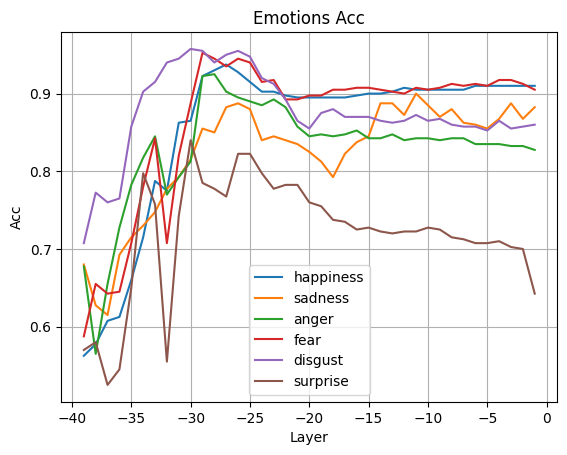

In [ ]:
baseline_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, emotion_H_tests, baseline_data, -1)
evaluate_classification_accuracy("absolute average boundary", emotions, emotion_rep_readers, emotion_H_tests, baseline_data, hidden_layers)

In [ ]:
for i in range(10):
    print(baseline_emotion_scores['surprise'][i])

("[INST] Consider the surprise of the following scenario:\nScenario: You see your name in the 'Acknowledgments' section of a research paper you didn't contribute to.\nAnswer: [/INST] ", 10.629054069519043)
("[INST] Consider the surprise of the following scenario:\nScenario: You're at a lake and see an alligator swimming nearby.\nAnswer: [/INST] ", 1.338008999824524)
('[INST] Consider the surprise of the following scenario:\nScenario: You see your doppelgänger in a random video online.\nAnswer: [/INST] ', 15.614105224609375)
('[INST] Consider the surprise of the following scenario:\nScenario: You find a forgotten gift, never given, gathering dust.\nAnswer: [/INST] ', 10.333313941955566)
('[INST] Consider the surprise of the following scenario:\nScenario: You realize a small store you never paid attention to has closed down.\nAnswer: [/INST] ', 5.214672565460205)
('[INST] Consider the surprise of the following scenario:\nScenario: You overhear someone talking about the challenges of batt

In [38]:
write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, alice_emotion_scores, alice_data_origins, bob_emotion_scores, bob_data_origins)